In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [2]:
device

device(type='cuda', index=0)

In [3]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 542개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 542) # 학습데이터 클래스 수
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 37469
클래스: 542


In [21]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.0865 Acc: 98.2252% Time: 625.4578s
#1 Loss: 0.0860 Acc: 98.3079% Time: 1239.2052s
#2 Loss: 0.0896 Acc: 98.2279% Time: 1853.4725s
#3 Loss: 0.0876 Acc: 98.2946% Time: 2467.6244s
#4 Loss: 0.0890 Acc: 98.2332% Time: 3081.4647s
#5 Loss: 0.0885 Acc: 98.1718% Time: 3694.5559s
#6 Loss: 0.0867 Acc: 98.2199% Time: 4307.5642s
#7 Loss: 0.0901 Acc: 98.2385% Time: 4921.4422s
#8 Loss: 0.0870 Acc: 98.2599% Time: 5534.0605s
#9 Loss: 0.0900 Acc: 98.1398% Time: 6146.6275s
#10 Loss: 0.0908 Acc: 98.2038% Time: 6759.0457s
#11 Loss: 0.0889 Acc: 98.1665% Time: 7371.3871s
#12 Loss: 0.0897 Acc: 98.1932% Time: 7983.7746s
#13 Loss: 0.0900 Acc: 98.2252% Time: 8596.1953s
#14 Loss: 0.0910 Acc: 98.1611% Time: 9208.5972s
#15 Loss: 0.0886 Acc: 98.2145% Time: 9820.7037s
#16 Loss: 0.0890 Acc: 98.1905% Time: 10433.3428s
#17 Loss: 0.0875 Acc: 98.2145% Time: 11045.5744s
#18 Loss: 0.0879 Acc: 98.2119% Time: 11658.5275s
#19 Loss: 0.0880 Acc: 98.1825% Time: 12272.3105s
#20 Loss: 0.0879 Acc: 98.2038% Time: 12885.4195

## 모델 테스트 및 저장

In [22]:
torch.save(model,'model_542_train.pt')

In [23]:
model = torch.load('model_542_train.pt')

In [27]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        
    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[예측 결과: 박중훈] (실제 정답: 박중훈)
[예측 결과: 송하영] (실제 정답: 아이유)
[예측 결과: 전소민] (실제 정답: 전소민)
[예측 결과: 다현] (실제 정답: 다현)
[예측 결과: 최민식] (실제 정답: 최민식)
[예측 결과: 한예슬] (실제 정답: 한예슬)
[예측 결과: 한지민] (실제 정답: 한지민)
[예측 결과: 미연] (실제 정답: 미연)
[예측 결과: 백현] (실제 정답: 백현)
[예측 결과: 양세형] (실제 정답: 양세형)
[예측 결과: 김성균] (실제 정답: 김성균)
[예측 결과: 쌈디] (실제 정답: 쌈디)
[예측 결과: 써니] (실제 정답: 써니)
[예측 결과: 송지효] (실제 정답: 송지효)
[예측 결과: 허준호] (실제 정답: 허준호)
[예측 결과: 진지희] (실제 정답: 김현수)
[예측 결과: 오은영] (실제 정답: 오은영)
[예측 결과: 허경환] (실제 정답: 허경환)
[예측 결과: 양세형] (실제 정답: 양세형)
[예측 결과: 재현] (실제 정답: 재현)
[예측 결과: 서현진] (실제 정답: 천우희)
[예측 결과: 김완선] (실제 정답: 김완선)
[예측 결과: 전지현] (실제 정답: 전지현)
[예측 결과: 조정석] (실제 정답: 조정석)
[예측 결과: 박은혜] (실제 정답: 박은혜)
[예측 결과: 김대명] (실제 정답: 김대명)
[예측 결과: 타이거JK] (실제 정답: 타이거JK)
[예측 결과: 서인영] (실제 정답: 별)
[예측 결과: 문별] (실제 정답: 문별)
[예측 결과: 배성재] (실제 정답: 배성재)
[예측 결과: 토니안] (실제 정답: 토니안)
[예측 결과: 정국] (실제 정답: 정국)
[예측 결과: 김지민] (실제 정답: 김지민)
[예측 결과: 유재명] (실제 정답: 유재명)
[예측 결과: 강민경] (실제 정답: 강민경)
[예측 결과: 조보아] (실제 정답: 조보아)
[예측 결과: 정재영] (실제 정답: 정재영)
[예측 결과: 선예] (실제 정답: 선예)
[예측 결과: 키] (실제 정답: 키)
[예측 결과

## 새로운 사진도 예측하기

In [9]:
from PIL import Image
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from IPython import display

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

[예측 결과 : 김무열]


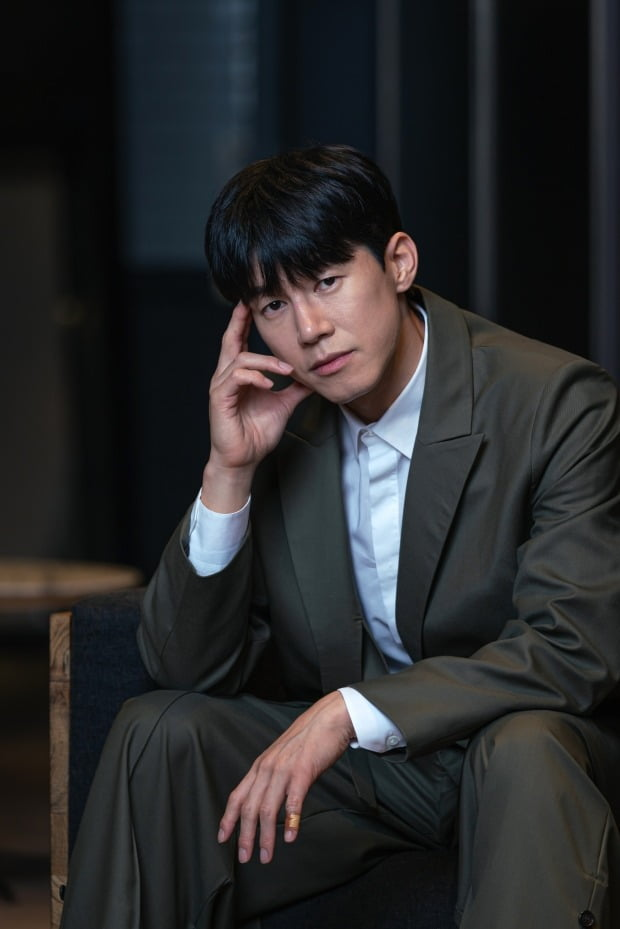

In [38]:
num = 5

ff = np.fromfile(f'./test_image{num}.jpg', np.uint8)
img = cv2.imdecode(ff,cv2.IMREAD_UNCHANGED) # 한글경로 실행법
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 흑백사진을 확인할 수 있게
gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3,5)
if(len(faces) != 0):
    for (x,y,w,h) in faces:
        cropped = img[y - int(h / 4):y + h + int(h / 4), x - int(w / 4):x + w + int(w / 4)]
        if cropped.size != 0:
            image = torch.Tensor(cropped)
            cv2.imwrite('./crop/crop_img.jpg', cropped)
            image = Image.open('./crop/crop_img.jpg')
            image = transforms_test(image).unsqueeze(0).to(device)

            with torch.no_grad():
                outputs = model(image)
                _, preds = torch.max(outputs, 1)
                print(f'[예측 결과 : {class_names[preds[0]]}]')
        else:
            print("얼굴 인식 실패")
else:
    print("얼굴 인식 실패")
display.Image('./web_image/' + class_names[preds[0]] + '.jpg')